<a href="https://colab.research.google.com/github/Patternic10/CSCI-4170-Project-in-AI-ML/blob/main/Homework5_T1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import numpy as np
import random
import time
import copy
import argparse

In [ ]:
image_dir = 'catsanddogs/PetImages'
# Define transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize images to 150x150
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load the dataset
dataset = datasets.ImageFolder(root='catsanddogs/PetImages', transform=transform)

# Split the dataset into training, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get class names
class_names = dataset.classes

In [ ]:
# Extract class names
class_names = sorted(os.listdir(image_dir))

# Number of Images
n_images = [len(os.listdir(os.path.join(image_dir, name))) for name in class_names]

print(f'Class Names: {class_names}')

print(f'No of images per class: {n_images}')

Class Names: ['Cat', 'Dog']
No of images per class: [12500, 12501]


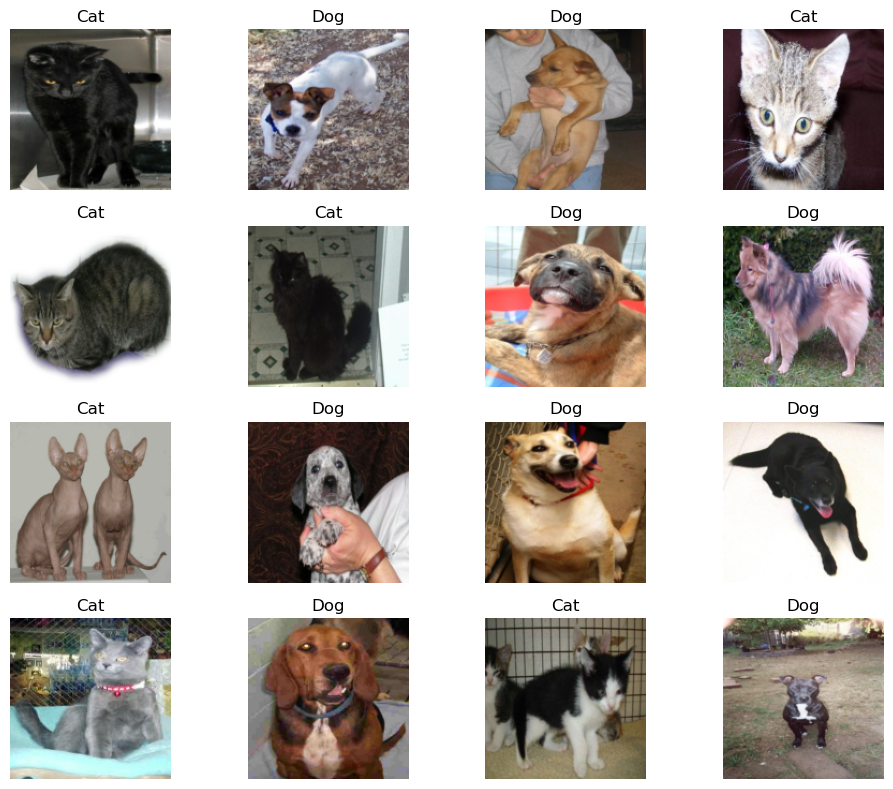

In [ ]:
# Function to unnormalize an image
def unnormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img * std + mean  # Unnormalize
    img = img.clamp(0, 1)   # Clamp values to [0, 1] range
    return img

# Extract a batch of images and labels
images, labels = next(iter(train_loader))

# Unnormalize the images
images = [unnormalize(img) for img in images]
images = torch.stack(images)  # Stack images back into a tensor

# Plot the images in a grid with class names
plt.figure(figsize=(10, 8))
for i in range(16):  # Assuming batch size is 32
    plt.subplot(4, 4, i + 1)  # 4 rows, 8 columns
    plt.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))  # Convert to HWC format for matplotlib
    plt.title(class_names[int(labels[i])])  # Add class name as title
    plt.axis('off')
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_base = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Conv1: 32 filters, 3x3 kernel
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # MaxPool1: 2x2 kernel
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Conv2: 64 filters, 3x3 kernel
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # MaxPool2: 2x2 kernel
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Conv3: 128 filters, 3x3 kernel
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # MaxPool3: 2x2 kernel
        )
        self.dense_layers = nn.Sequential(
            nn.Flatten(),                                # Flatten the output
            nn.Linear(128 * 18 * 18, 512),               # Dense layer with 512 units
            nn.ReLU(),
            nn.Linear(512, 1),                           # Output layer with 1 unit (binary classification)
            nn.Sigmoid()                                 # Sigmoid activation for binary classification
        )

    def forward(self, x):
        x = self.conv_base(x)
        x = self.dense_layers(x)
        return x

# Initialize the model
model = CNN()

In [ ]:
# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate of 0.001

In [ ]:
# Training loop
num_epochs = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images)
            val_loss += criterion(outputs.squeeze(), labels).item()
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {100 * correct/total:.2f}%")

Epoch [1/15], Loss: 0.6932
Validation Loss: 0.6932, Validation Accuracy: 50.14%
Epoch [2/15], Loss: 0.6933
Validation Loss: 0.6931, Validation Accuracy: 50.18%
Epoch [3/15], Loss: 0.6926
Validation Loss: 0.6664, Validation Accuracy: 57.38%
Epoch [4/15], Loss: 0.5727
Validation Loss: 0.5147, Validation Accuracy: 74.79%
Epoch [5/15], Loss: 0.4440
Validation Loss: 0.4629, Validation Accuracy: 77.03%
Epoch [6/15], Loss: 0.3466
Validation Loss: 0.4314, Validation Accuracy: 80.51%
Epoch [7/15], Loss: 0.2154
Validation Loss: 0.5103, Validation Accuracy: 80.35%
Epoch [8/15], Loss: 0.0842
Validation Loss: 0.6757, Validation Accuracy: 79.75%
Epoch [9/15], Loss: 0.0451
Validation Loss: 0.9277, Validation Accuracy: 79.59%
Epoch [10/15], Loss: 0.0246
Validation Loss: 1.0661, Validation Accuracy: 79.71%
Epoch [11/15], Loss: 0.0209
Validation Loss: 1.3202, Validation Accuracy: 79.91%
Epoch [12/15], Loss: 0.0362
Validation Loss: 1.4208, Validation Accuracy: 79.03%
Epoch [13/15], Loss: 0.0242
Validatio

In [ ]:
# Test the model
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images)
        test_loss += criterion(outputs.squeeze(), labels).item()
        predicted = (outputs.squeeze() > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {100 * correct/total:.2f}%")

Test Loss: 1.8201, Test Accuracy: 79.73%


In [ ]:
# Test the model
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images)
        test_loss += criterion(outputs.squeeze(), labels).item()
        predicted = (outputs.squeeze() > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {100 * correct/total:.2f}%")

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
# Initialize model
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/kazeej/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100.0%


In [ ]:
# Freeze the convolutional base
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 1),
    nn.Sigmoid()
)

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Only optimize the final layer

In [ ]:
# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)

        # Forward pass
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images).squeeze()
            val_loss += criterion(outputs, labels).item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {100 * correct/total:.2f}%")

Epoch [1/15], Loss: 0.0971
Validation Loss: 0.0556, Validation Accuracy: 97.56%
Epoch [2/15], Loss: 0.0704
Validation Loss: 0.0485, Validation Accuracy: 97.92%
Epoch [3/15], Loss: 0.0591
Validation Loss: 0.0440, Validation Accuracy: 97.96%
Epoch [4/15], Loss: 0.0531
Validation Loss: 0.0486, Validation Accuracy: 98.00%
Epoch [5/15], Loss: 0.0480
Validation Loss: 0.0445, Validation Accuracy: 98.16%
Epoch [6/15], Loss: 0.0386
Validation Loss: 0.0514, Validation Accuracy: 97.88%
Epoch [7/15], Loss: 0.0386
Validation Loss: 0.0580, Validation Accuracy: 97.80%
Epoch [8/15], Loss: 0.0368
Validation Loss: 0.0650, Validation Accuracy: 97.48%
Epoch [9/15], Loss: 0.0327
Validation Loss: 0.0672, Validation Accuracy: 97.56%
Epoch [10/15], Loss: 0.0272
Validation Loss: 0.0546, Validation Accuracy: 97.96%
Epoch [11/15], Loss: 0.0248
Validation Loss: 0.0609, Validation Accuracy: 97.64%
Epoch [12/15], Loss: 0.0261
Validation Loss: 0.0804, Validation Accuracy: 97.40%
Epoch [13/15], Loss: 0.0252
Validatio

In [ ]:
# Test the model
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images).squeeze()
        test_loss += criterion(outputs, labels).item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {100 * correct/total:.2f}%")

Test Loss: 0.0650, Test Accuracy: 97.68%


In [ ]:

# Define transformations for training data (with augmentation)
train_transform = transforms.Compose([
    transforms.RandomRotation(30),               # Random rotation up to 30 degrees
    transforms.RandomHorizontalFlip(),           # Random horizontal flip
    transforms.RandomResizedCrop(150),           # Random crop and resize to 150x150
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Random color jitter
    transforms.ToTensor(),                       # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Define transformations for validation and test data (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((150, 150)),               # Resize images to 150x150
    transforms.ToTensor(),                       # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load the dataset
train_dataset = datasets.ImageFolder(root=image_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=image_dir, transform=test_transform)

# Split the dataset into training, validation, and test sets
train_size = int(0.8 * len(train_dataset))
val_size = int(0.1 * len(train_dataset))
test_size = len(train_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get class names
class_names = train_dataset.dataset.classes

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_base = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Conv1: 32 filters, 3x3 kernel
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # MaxPool1: 2x2 kernel
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Conv2: 64 filters, 3x3 kernel
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # MaxPool2: 2x2 kernel
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # Conv3: 128 filters, 3x3 kernel
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),       # MaxPool3: 2x2 kernel
        )
        self.dense_layers = nn.Sequential(
            nn.Flatten(),                                # Flatten the output
            nn.Linear(128 * 18 * 18, 512),               # Dense layer with 512 units
            nn.ReLU(),
            nn.Linear(512, 1),                           # Output layer with 1 unit (binary classification)
            nn.Sigmoid()                                 # Sigmoid activation for binary classification
        )

    def forward(self, x):
        x = self.conv_base(x)
        x = self.dense_layers(x)
        return x

# Initialize the model
model = CNN().to(device)

In [ ]:
# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)

        # Forward pass
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images).squeeze()
            val_loss += criterion(outputs, labels).item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {100 * correct/total:.2f}%")

Epoch [1/15], Loss: 0.6667
Validation Loss: 0.6417, Validation Accuracy: 62.71%
Epoch [2/15], Loss: 0.6057
Validation Loss: 0.5997, Validation Accuracy: 66.83%
Epoch [3/15], Loss: 0.5661
Validation Loss: 0.5624, Validation Accuracy: 70.63%
Epoch [4/15], Loss: 0.5461
Validation Loss: 0.5401, Validation Accuracy: 73.79%
Epoch [5/15], Loss: 0.5346
Validation Loss: 0.5244, Validation Accuracy: 73.91%
Epoch [6/15], Loss: 0.5168
Validation Loss: 0.5170, Validation Accuracy: 74.67%
Epoch [7/15], Loss: 0.5112
Validation Loss: 0.4896, Validation Accuracy: 76.15%
Epoch [8/15], Loss: 0.4977
Validation Loss: 0.5017, Validation Accuracy: 75.83%
Epoch [9/15], Loss: 0.4861
Validation Loss: 0.5114, Validation Accuracy: 76.71%
Epoch [10/15], Loss: 0.4692
Validation Loss: 0.4615, Validation Accuracy: 78.11%
Epoch [11/15], Loss: 0.4624
Validation Loss: 0.4442, Validation Accuracy: 79.19%
Epoch [12/15], Loss: 0.4539
Validation Loss: 0.4282, Validation Accuracy: 79.79%
Epoch [13/15], Loss: 0.4425
Validatio

In [ ]:
# Test the model
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().to(device)
        outputs = model(images).squeeze()
        test_loss += criterion(outputs, labels).item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {100 * correct/total:.2f}%")

Test Loss: 0.4072, Test Accuracy: 80.05%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils

In [ ]:
import torch
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
#training_data = np.load('CIFAR-10/training_data.npy')
# Normalize training data
#training_data = training_data / 255.0
#training_data = torch.tensor(training_data, dtype=torch.float32)

#testing_data = np.load('CIFAR-10/testing_data.npy')
# Normalize testing data
#testing_data = testing_data / 255.0
#testing_data = torch.tensor(testing_data, dtype=torch.float32)

#training_label = np.load('CIFAR-10/training_label.npy')
#integer_trainlabel = training_label * 1

# Convert training label to one-hot matrix
#training_label = torch.reshape(torch.nn.functional.one_hot(torch.tensor(integer_trainlabel, dtype=torch.long), 10).float(), (-1, 10))

#testing_label = np.load('CIFAR-10/testing_label.npy')
#integer_testlabel = testing_label * 1
# Convert testing label to one-hot matrix
#testing_label = torch.reshape(torch.nn.functional.one_hot(torch.tensor(integer_testlabel, dtype=torch.long), 10).float(), (-1, 10))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 128
latent_dim = 128
learning_rate = 1e-3
epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your data
training_data = np.load('CIFAR-10/training_data.npy')
training_data = training_data / 255.0  # Normalize to [0, 1]
training_data = torch.tensor(training_data, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to (N, C, H, W)

testing_data = np.load('CIFAR-10/testing_data.npy')
testing_data = testing_data / 255.0  # Normalize to [0, 1]
testing_data = torch.tensor(testing_data, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to (N, C, H, W)


# Create DataLoader
train_dataset = TensorDataset(training_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(testing_data)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the VAE
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 32x16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 64x8x8
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 128x4x4
            nn.ReLU(),
            nn.Flatten(),  # 128*4*4 = 2048
        )

        self.fc_mu = nn.Linear(2048, latent_dim)
        self.fc_logvar = nn.Linear(2048, latent_dim)

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 2048)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 64x8x8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 32x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # 3x32x32
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(-1, 128, 4, 4)  # Reshape to match decoder input
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [ ]:
# Loss Function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Initialize VAE and Optimizer
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Training Loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = data[0].to(device)  # Extract tensor from list
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(train_loader.dataset):.4f}")


Epoch 1/20, Loss: 1925.8177
Epoch 2/20, Loss: 1848.2387
Epoch 3/20, Loss: 1835.6208
Epoch 4/20, Loss: 1830.6554
Epoch 5/20, Loss: 1826.9851
Epoch 6/20, Loss: 1825.1273
Epoch 7/20, Loss: 1823.5401
Epoch 8/20, Loss: 1822.5207
Epoch 9/20, Loss: 1821.9029
Epoch 10/20, Loss: 1821.0274
Epoch 11/20, Loss: 1820.4170
Epoch 12/20, Loss: 1819.9456
Epoch 13/20, Loss: 1819.6476
Epoch 14/20, Loss: 1819.1017
Epoch 15/20, Loss: 1818.8390
Epoch 16/20, Loss: 1818.6403
Epoch 17/20, Loss: 1818.2671
Epoch 18/20, Loss: 1817.9309
Epoch 19/20, Loss: 1817.8442
Epoch 20/20, Loss: 1817.6421


In [ ]:
# Generate New Images
model.eval()
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)  # Sample 64 random latent vectors
    samples = model.decode(z).cpu()

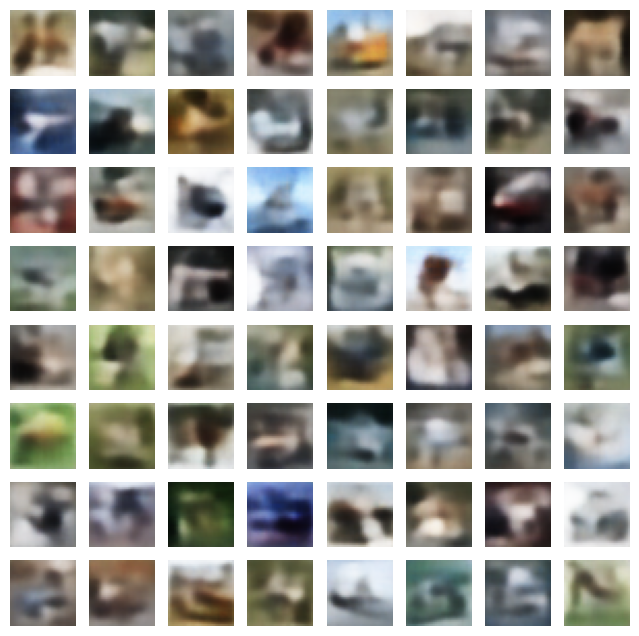

In [ ]:
# Plot Generated Images
def show_images(images):
    images = images.permute(0, 2, 3, 1).numpy()  # Convert to (N, H, W, C)
    plt.figure(figsize=(8, 8))
    for i in range(64):
        plt.subplot(8, 8, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.show()

show_images(samples)

In [ ]:
#GAN
# Hyperparameters
batch_size = 128
latent_dim = 100
learning_rate = 2e-4
epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Generator
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        self.model = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=1, padding=0),  # 512x4x4
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 256x8x8
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 128x16x16
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1),  # 3x32x32
            nn.Tanh(),  # Output in [-1, 1]
        )

    def forward(self, z):
        return self.model(z)

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            # Input: 3x32x32
            nn.Conv2d(3, 128, kernel_size=4, stride=2, padding=1),  # 128x16x16
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 256x8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 512x4x4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),  # 1x1x1
            nn.Flatten(),
            nn.Sigmoid(),  # Output probability
        )

    def forward(self, img):
        return self.model(img)



In [ ]:
# Initialize Generator and Discriminator
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()

Epoch [1/20], Step [0/391], d_loss: 100.0000, g_loss: 0.0000
Epoch [1/20], Step [100/391], d_loss: 100.0000, g_loss: 0.0000
Epoch [1/20], Step [200/391], d_loss: 100.0000, g_loss: 0.0000
Epoch [1/20], Step [300/391], d_loss: 100.0000, g_loss: 0.0000
Epoch [2/20], Step [0/391], d_loss: 100.0000, g_loss: 0.0000
Epoch [2/20], Step [100/391], d_loss: 100.0000, g_loss: 0.0000
Epoch [2/20], Step [200/391], d_loss: 100.0000, g_loss: 0.0000
Epoch [2/20], Step [300/391], d_loss: 100.0000, g_loss: 0.0000
Epoch [3/20], Step [0/391], d_loss: 100.0000, g_loss: 0.0000
Epoch [3/20], Step [100/391], d_loss: 100.0000, g_loss: 0.0000
Epoch [3/20], Step [200/391], d_loss: 100.0000, g_loss: 0.0000
Epoch [3/20], Step [300/391], d_loss: 100.0000, g_loss: 0.0000
Epoch [4/20], Step [0/391], d_loss: 100.0000, g_loss: 0.0000
Epoch [4/20], Step [100/391], d_loss: 100.0000, g_loss: 0.0000
Epoch [4/20], Step [200/391], d_loss: 100.0000, g_loss: 0.0000
Epoch [4/20], Step [300/391], d_loss: 100.0000, g_loss: 0.0000


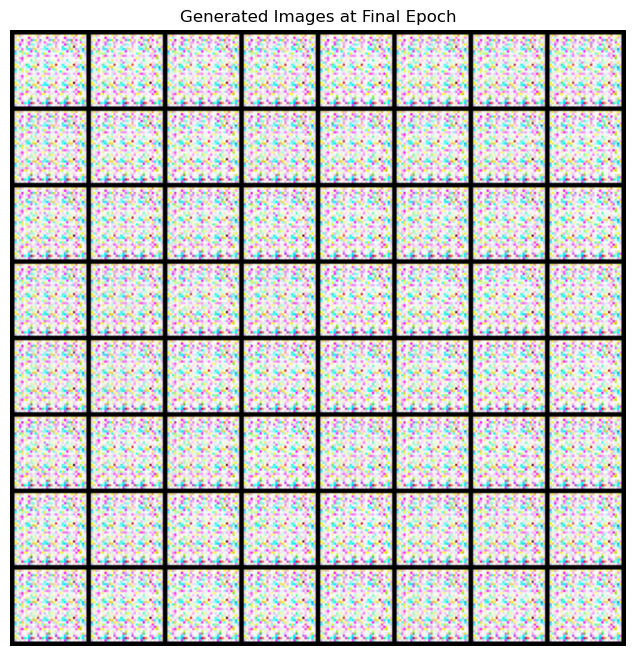

In [ ]:
# Training Loop
for epoch in range(epochs):
    for i, data in enumerate(train_loader):
        real_images = data[0].to(device)
        batch_size = real_images.size(0)

        # Labels for real and fake images
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        optimizer_D.zero_grad()

        # Real images
        real_outputs = discriminator(real_images)
        real_outputs = real_outputs.view(-1, 1)  # Reshape to [batch_size, 1]
        d_loss_real = criterion(real_outputs, real_labels)

        # Fake images
        z = torch.randn(batch_size, latent_dim, 1, 1).to(device)
        fake_images = generator(z)
        fake_outputs = discriminator(fake_images.detach())
        fake_outputs = fake_outputs.view(-1, 1)
        d_loss_fake = criterion(fake_outputs, fake_labels)

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()

        # Generate fake images and compute generator loss
        fake_outputs = discriminator(fake_images)
        fake_outputs = fake_outputs.view(-1, 1)
        #print(fake_outputs.shape)
        #print(real_labels.shape)
        g_loss = criterion(fake_outputs, real_labels)

        g_loss.backward()
        optimizer_G.step()

        # Print losses
        if i % 100 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Step [{i}/{len(train_loader)}], "
                  f"d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}")

    # Generate and save images after each epoch
    if epoch == epochs - 1:  # Check if it's the last epoch
        with torch.no_grad():
            z = torch.randn(64, latent_dim, 1, 1).to(device)
            generated_images = generator(z).cpu()

            # Rescale images to [0, 1] for visualization
            generated_images = (generated_images + 1) / 2

            # Save the generated images
            vutils.save_image(
                generated_images,
                "generated_images/final_epoch.png",  # Save as a single file
                nrow=8,  # Number of images per row in the grid
                normalize=True,
            )

            # Plot generated images
            plt.figure(figsize=(8, 8))
            plt.axis("off")
            plt.title("Generated Images at Final Epoch")
            plt.imshow(np.transpose(vutils.make_grid(generated_images, padding=2, normalize=True), (1, 2, 0)))
            plt.show()